# Name: Praveen Balireddy
# Roll: 2018201052

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

In [2]:
## Adding seed for numpy
np.random.seed(60)

In [3]:
def splitData(X ,Y, test_size):
    '''
    Function to split data into test-Validation
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 ,random_state = 10)
    return (X_train, X_test, y_train, y_test)

## Reading Input

In [4]:
admission_orig_df = pd.read_csv("AdmissionDataset/data.csv")

In [7]:
admission_orig_cols = ['Serial_No', 'GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance_of_Admit']
admission_orig_df.columns = admission_orig_cols

## Data Exploration

In [11]:
# Dropping Serial Number
admission_df = admission_orig_df.drop(columns=['Serial_No'])

## Splitting data into train(80%) and validation(20%)

In [12]:
admission_train_X, admission_val_X, admission_train_Y, admission_val_Y = splitData(admission_df.iloc[:,admission_df.columns != 'Chance_of_Admit'], admission_df['Chance_of_Admit'], test_size=0.2)

# Linear Regression

### Helper Functions

In [13]:
def MSE(X, Y, theta, lamda, regularization):
    '''
    Function to Calculate the mean squared error
    '''
    m = len(Y)
    return np.sum((np.dot(X, theta.T) - Y) ** 2)/(2 * m)
    
def makeCoeffDF(coeffs, type_):
    '''
    Function to create dataframe for coefficients for each type in type_
    '''
    coeff_cols = ['Type','GRE_Score', 'TOEFL_Score', 
                  'University_Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Intercept']
    temp = [[type_]+list(coeffs.flatten())]
    coeff_df = pd.DataFrame([[type_]+list(coeffs.flatten())], columns=coeff_cols)
    return coeff_df

In [69]:
class MyLinearRegressor:
    def __init__(self, cost_measure = MSE, learning_rate = 0.01,
                 no_iterations = 1000, lamda=1, regularization="lasso"):
        self.cost_measure = cost_measure
        self.cost_name = cost_measure.__name__
        self.alpha = learning_rate
        self.iterations = no_iterations
        self.lamda = lamda
        self.regularization = regularization
    
    def normalize_X(self, X):
        X_normalized = (X - self.X_mean)/self.X_var
        return X_normalized

    def normalize_Y(self, Y):
        return Y
        Y_normalized = (Y - self.Y_mean)/self.Y_var
        return Y_normalized
    
    def fit(self, X, Y):
        #### m = no of examples, n = no of features
        ### X : shape = mxn
        ### Y : shape = 1xm
        self.X_mean = X.mean()
        self.X_var = X.std()
        self.Y_mean = Y.mean()
        self.Y_var = Y.std()
        temp = list(X.columns.values)
        temp.append('Intercept')
        self.columns_X = temp
        
        X  = self.normalize_X(X)
        X_temp = X.values
        c = np.ones((1, len(X)))  ### shape = 1xm
        X_temp = np.concatenate((X, c.T), axis=1) ## Shape : mxn
        theta = np.zeros((1, len(X_temp[0]))) ## shape: 1 X n 
        Y_temp = Y.values.reshape(len(X),1)  ## shape : (m,1)
#         print(X_temp)
        theta, cost_hist = self.gradient_descent(theta, X_temp, Y_temp, self.alpha, self.iterations)
#         print("final_cost {0}".format(cost_hist[-1]))
        self.theta = theta
        self.coef_ = theta.flatten()[:-1]
        self.cost_hist = cost_hist
        self.intercept_ = theta.flatten()[-1:]
#         print(theta)
    
    def predict(self, X):
        X = self.normalize_X(X)
        c = np.ones((1, len(X)))  ### shape = 1xm
        X_temp = np.concatenate((X, c.T), axis=1) ## Shape : kxn
        y_pred = np.dot(X_temp,self.theta.T)
#         y_pred = y_pred*self.Y_var + self.Y_mean
        return y_pred.flatten()

    def calcError(self, X, Y):
        Y = np.array(Y).reshape(len(Y),-1)
        X = self.normalize_X(X)
        c = np.ones((1, len(X)))  ### shape = 1xm
        X_temp = np.concatenate((X, c.T), axis=1) ## Shape : kxn
        y_pred = np.dot(X_temp,self.theta.T)
        res = y_pred.flatten()
        return MSE(X_temp, Y, self.theta, self.lamda, self.regularization)
    
    def allCoeffs(self):
        coeffs = list(self.coef_) + list(self.intercept_)
        coeffs = np.array(coeffs).reshape(1, len(coeffs))
        return coeffs
    
    def plotCoeffsAndCost(self, theta_history, cost_history, iterations):
        x_values = range(iterations)
        theta_df = pd.DataFrame(theta_history, columns=self.columns_X)
        theta_df = theta_df.iloc[:,theta_df.columns != 'Intercept']
        # style
        plt.rcParams["figure.figsize"] = (10,7.5)
        plt.subplot(1, 1, 1)
        plt.style.use('seaborn-darkgrid')

        # create a color palette
        palette = plt.get_cmap('Set1')

        # multiple line plot
        num=0
        for column in theta_df:
            num+=1
            plt.plot(x_values, theta_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

        # Add legend
        plt.legend(loc=2, ncol=2)

        # Add titles
        plt.title("Coefficient Variation", loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel('iteration')
        plt.ylabel('Coefficients')
        
#         plt.subplot(2, 1, 2)
#         plt.plot(range(iterations), cost_history)
#         plt.xlabel('iteration')
#         plt.ylabel('cost')
        
    def gradient_descent(self, theta, X, Y, alpha, iterations):
        cost_history = [0] * iterations
        theta_history = [0] * iterations
        m = len(Y)

        for iteration in range(iterations):
            # Hypothesis Values
            h = np.dot(X,theta.T) ## shape : (m,1)
            # Difference b/w Hypothesis and Actual Y
            if(self.cost_name == "MSE"):
                loss = h - Y ## shape: (m,1)
                # Gradient Calculation
                gradient = np.dot(X.T,loss) / m  ##shape : (n,1)
                ## Lasso/Ridge component
                lamda_term = None
                if(self.regularization == "lasso"):
                    lamda_term = self.lamda*np.nan_to_num(np.divide(np.absolute(theta.T),theta.T))/m
                elif(self.regularization == "ridge"):
                    lamda_term = self.lamda*np.nan_to_num(theta.T)/m
#                 gradient[:,:-1] += lamda_term[:,:-1]
                lamda_term[-1][-1] = 0
#                 print(gradient)
#                 print(lamda_term)
                gradient += lamda_term
                # Changing Values of B using Gradient
                theta = theta - alpha * (gradient.T)
            
            theta_history[iteration] = theta.flatten()
            cost = self.cost_measure(X, Y, theta, self.lamda, self.regularization)
            cost_history[iteration] = cost
        self.plotCoeffsAndCost(theta_history, cost_history, iterations)
        return theta, cost_history

# Question - 1
Implement Lasso regression also known as L1 regularisation and plot graph between regularisation coefficient λ and error

Lasso regression is also called as gradient descent with L1 regularization.

Here we add L1 regularization term to cost function which helps reduce complexity of the model, hence better performace during testing.

The Cost function is represented by
$$J(\theta) = \frac{1}{2m}[\sum_{i=1}^m(h_\theta (x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^n \left|\left|\theta_j\right|\right|_1]$$

So $\theta$ can be updated using
$$\theta = \theta - (\alpha/m)*((h_\theta (x^{(i)}) - y^{(i)}) + \lambda*\theta/\left|\theta\right|)$$

L1 2-D Visualization:
![L1](L1.png)

In [15]:
lr = MyLinearRegressor(MSE, 0.01, 1000, 1,"lasso")
lr.fit(admission_train_X, admission_train_Y)
lr.calcError(admission_val_X, admission_val_Y)

0.0028075781928406348

In [16]:
coeff_Df = makeCoeffDF(lr.allCoeffs(), "lasso")
coeff_Df

,Type,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,lasso,0.031119,0.015661,0.006239,0.000032,0.013799,0.063963,0.010432,0.720302


In [56]:
lamda = 0.1
errors = []
lambdas = []
while(lamda < 100):
    lr = MyLinearRegressor(MSE, 0.01, 1000, lamda, "lasso")
    lr.fit(admission_train_X, admission_train_Y)
    lambdas.append(lamda)
    errors.append(lr.calcError(admission_val_X, admission_val_Y))
    if(lamda < 1):
        lamda += 0.1
    else:
        lamda += 1

Text(0.5,1,'Error vs lamda (Lasso)')

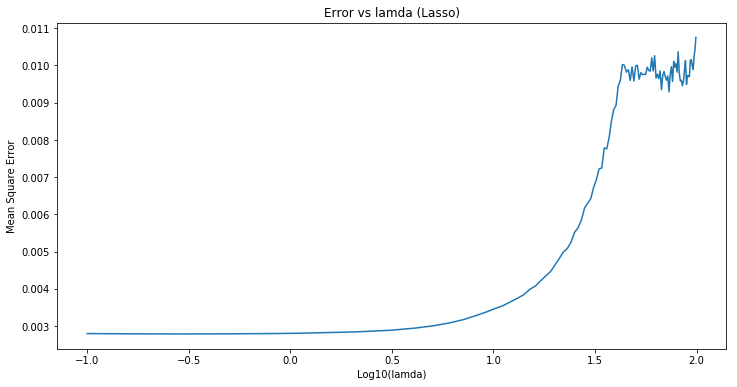

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(np.log10(lambdas), errors)
ax.set_xlabel("Log10(lamda)")
ax.set_ylabel("Mean Square Error")
ax.set_title("Validation Error vs lamda (Lasso)")

### Observations:
1. As λ increases, the weights decrease and at some point almost get close to zero, hence the validation error increases with λ.

# Question - 2
Implement Ridge regression also known as L2 regularisation and plot graph between regularisation coefficient λ and error.

Ridge Regression also called as Linear regression with L2 regularization.

Here, we add L2 regularization term to the cost function which helps in reducing the complexity of the model, hence better prediction during testing.

The Cost function is represented by
$$J(\theta) = \frac{1}{2m}[\sum_{i=1}^m(h_\theta (x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^n \left|\left|\theta_j\right|\right|_2]$$

where $\left|\left|\theta\right|\right|_2$ is $\theta^2$

So $\theta$ can be updated using
$$\theta = (1-(\alpha*\lambda)/m)\theta - (\alpha/m)*((h_\theta (x^{(i)}) - y^{(i)})$$

L2 regularization using normal equation for linear regression:
$$\theta = ((X^T*X + \lambda*I)^-1)*X^T*Y$$ * is matrix product, 
I is (n+1)x(n+1) identity matrix with such that I[-1][-1] = 0 for bias

L2 2-D Visualization:
![L2](L2.png)

In [19]:
lr = MyLinearRegressor(MSE, 0.01, 1000, 1,"ridge")
lr.fit(admission_train_X, admission_train_Y)
lr.calcError(admission_val_X, admission_val_Y)

0.002807009218181321

In [20]:
coeff_Df2 = makeCoeffDF(lr.allCoeffs(), "ridge")
coeff_Df2

,Type,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,ridge,0.031626,0.016758,0.00759,-0.002239,0.015489,0.064015,0.012015,0.720302


In [22]:
lamda = 0.1
errors = []
lambdas = []
while(lamda < 100):
    lr = MyLinearRegressor(MSE, 0.01, 1000, lamda, "ridge")
    lr.fit(admission_train_X, admission_train_Y)
    lambdas.append(lamda)
    errors.append(lr.calcError(admission_val_X, admission_val_Y))
    if(lamda < 1):
        lamda += 0.1
    else:
        lamda += 1

Text(0.5,1,'Error vs lamda (Ridge)')

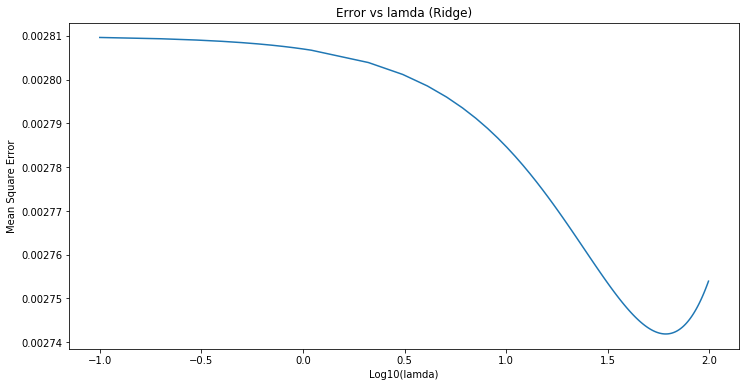

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(np.log10(lambdas), errors)
ax.set_xlabel("Log10(lamda)")
ax.set_ylabel("Mean Square Error")
ax.set_title("Validation Error vs lamda (Ridge)")

### Observations:
1. Increasing λ decreases the complexity of the model, hence the bias increases, and the validation error decreases. But after a certain point, the error increases as the weights become negligibly small and the model is underfit.

# Question - 3
Analyse how the hyper-parameter λ plays a role in deciding between bias and variance

## Lasso

In [52]:
lamda = 0.1
test_errors = []
train_errors = []
lambdas = []
while(lamda < 50):
#     print("lamda: {0}".format(lamda))
    lr = MyLinearRegressor(MSE, 0.01, 1000, lamda, "lasso")
    lr.fit(admission_train_X, admission_train_Y)
    lambdas.append(lamda)
    test_errors.append(lr.calcError(admission_val_X, admission_val_Y))
    train_errors.append(lr.calcError(admission_train_X, admission_train_Y))
    if(int(lamda) < 1):
        lamda += 0.1
    else:
        lamda += 1

Text(0.5,1,'Error vs lamda (Lasso)')

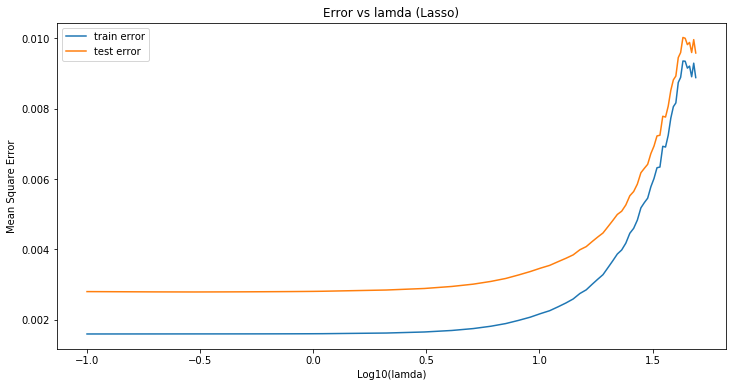

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(np.log10(lambdas), train_errors, label="train error")
ax.plot(np.log10(lambdas), test_errors, label="test error")
ax.legend(loc='upper left')
ax.set_xlabel("Log10(lamda)")
ax.set_ylabel("Mean Square Error")
ax.set_title("Error vs lamda (Lasso)")

## Ridge

In [54]:
lamda = 0.1
test_errors = []
train_errors = []
lambdas = []
while(lamda < 100):
    lr = MyLinearRegressor(MSE, 0.01, 1000, lamda, "ridge")
    lr.fit(admission_train_X, admission_train_Y)
    lambdas.append(lamda)
    test_errors.append(lr.calcError(admission_val_X, admission_val_Y))
    train_errors.append(lr.calcError(admission_train_X, admission_train_Y))
    if(lamda < 1):
        lamda += 0.1
    else:
        lamda += 1

Text(0.5,1,'Error vs lamda (Ridge)')

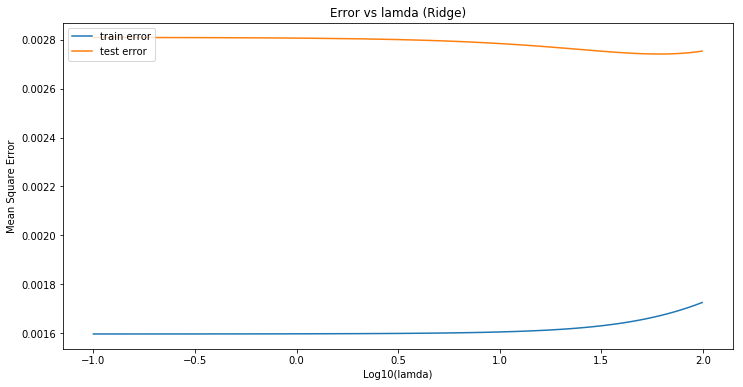

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(np.log10(lambdas), train_errors, label="train error")
ax.plot(np.log10(lambdas), test_errors, label="test error")
ax.legend(loc='upper left')
ax.set_xlabel("Log10(lamda)")
ax.set_ylabel("Mean Square Error")
ax.set_title("Error vs lamda (Ridge)")

### Observations:
1. Increasing λ decreases the complexity of the model, hence the bias increases, and the validation error decreases(train error increases). But after a certain point, both errors increase as the weights become negligibly small and the model is underfit.
2. For Lasso, initially, the error is almost constant but after a point, both the validation and training errors increase due to underfitting.

# Question - 4
Analyse how the two different regularisation techniques affect regression weights in terms of their values and what are the differences between the two.

### Lasso(L1)

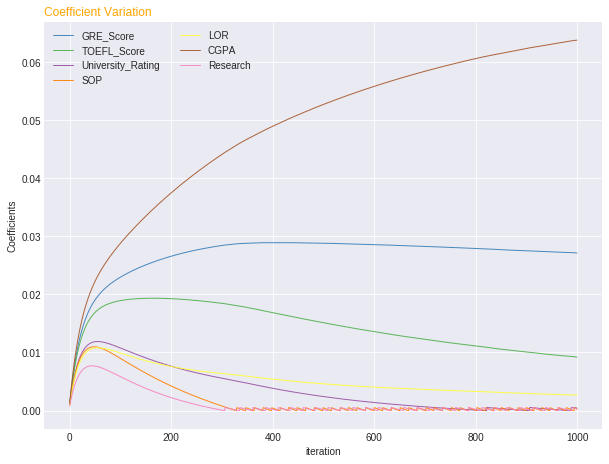

In [70]:
lr = MyLinearRegressor(MSE, 0.01, 1000, 10,"lasso")
lr.fit(admission_train_X, admission_train_Y)
lr.calcError(admission_val_X, admission_val_Y)

coeff_Df = makeCoeffDF(lr.allCoeffs(), "lasso")

### Ridge(L2)

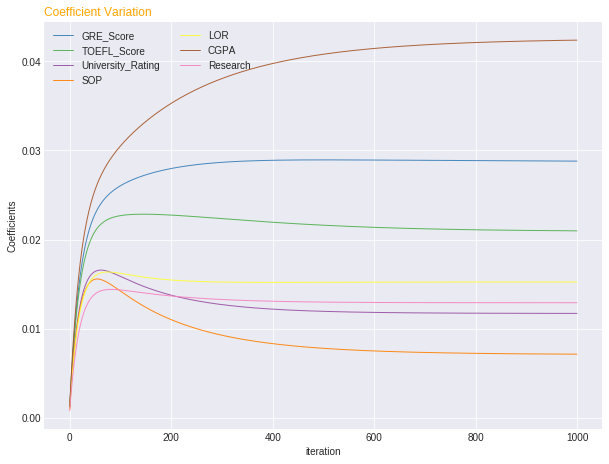

In [71]:
lr = MyLinearRegressor(MSE, 0.01, 1000, 100,"ridge")
lr.fit(admission_train_X, admission_train_Y)
lr.calcError(admission_val_X, admission_val_Y)

coeff_Df2 = makeCoeffDF(lr.allCoeffs(), "ridge")
coeff_compare = coeff_Df.append(coeff_Df2)

In [38]:
coeff_compare

,Type,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,lasso,-0.000090,-0.000655,0.001459,0.000187,0.003059,0.003815,0.000117,0.720302
0,ridge,0.028797,0.020974,0.011710,0.007133,0.015235,0.042375,0.012909,0.720302


### Observations:
1. From the above graphs and table it can be seen that for high λ, lasso(L1) decreases the weights drastically, compared to ridge(L2). This happens because Lasso, is L1 regularization(power 1), so it tries to make the weights absolute zero, whereas ridge is L2 regularization(power of 2), so it makes the weights close to zero but not as much as lasso.
2. Due to its strong nature of minimizing the coefficients, lasso is used for feature selection. Also, Since lasso regularization term is unitary power, it is highly stable towards outliers.
4. L2 Ridge is unstable due to the square power nature of its regularization term, hence giving out a large error when theta > 1, but usually gives a good solution as doesnt make the coefficients zero.

# Question - 5
In this part implement regression with k-fold cross validation. Analyse how behavior changes with different values of k. Also implement a variant of this which is the leave-one-out cross validation

### K-Fold Cross Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.
The general procedure is as follows:

    1. Shuffle the dataset randomly.
    2. Split the dataset into k groups
    3. For each unique group:
        - Take the group as a hold out or test data set
        - Take the remaining groups as a training data set
        - Fit a model on the training set and evaluate it on the test set
        - Retain the evaluation score and discard the model
    4. Summarize the performance of the model using the sample of model evaluation scores

K-Fold Cross Validation can also be used to assess the bias and variance of the model in the following ways:
    - If the variance among the different validation errors is high, implies the model has high variance.
    - If the mean of the validation errors in high, implies the model has high bias.

In [31]:
X = admission_df.iloc[:,admission_df.columns != 'Chance_of_Admit']
y = admission_df['Chance_of_Admit']

In [50]:
avg_r2_score = []
avg_mse = []
k_vals = []
for i in range(2, 41):
    errors = []
    r2_scores = []
    cv = KFold(n_splits=i, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lr = MyLinearRegressor(MSE, 0.01, 1000, 1e-15,"lasso")
        lr.fit(X_train, y_train)
        errors.append(lr.calcError(X_test, y_test))
        r2_scores.append(metrics.r2_score(y_test, lr.predict(X_test)))
    avg_r2_score.append(np.mean(r2_scores))
    avg_mse.append(np.mean(errors))
    k_vals.append(i)
    
lasso_avg_r2_score = []
lasso_avg_mse = []
for i in range(2, 41):
    errors = []
    r2_scores = []
    cv = KFold(n_splits=i, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lr = MyLinearRegressor(MSE, 0.01, 1000, 10,"lasso")
        lr.fit(X_train, y_train)
        errors.append(lr.calcError(X_test, y_test))
        r2_scores.append(metrics.r2_score(y_test, lr.predict(X_test)))
    lasso_avg_r2_score.append(np.mean(r2_scores))
    lasso_avg_mse.append(np.mean(errors))

ridge_avg_r2_score = []
ridge_avg_mse = []
for i in range(2, 41):
    errors = []
    r2_scores = []
    cv = KFold(n_splits=i, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lr = MyLinearRegressor(MSE, 0.01, 1000, 100,"ridge")
        lr.fit(X_train, y_train)
        errors.append(lr.calcError(X_test, y_test))
        r2_scores.append(metrics.r2_score(y_test, lr.predict(X_test)))
    ridge_avg_r2_score.append(np.mean(r2_scores))
    ridge_avg_mse.append(np.mean(errors))

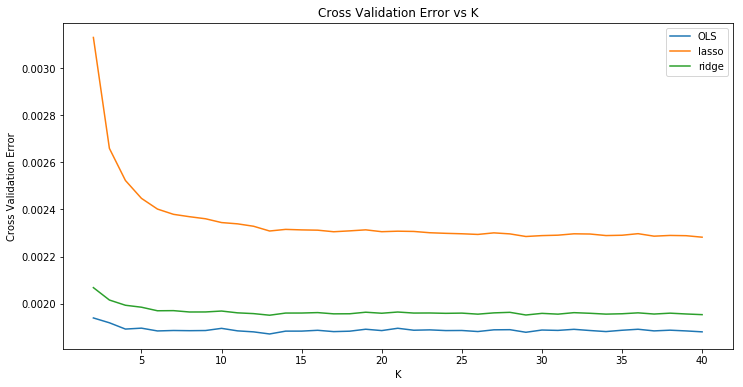

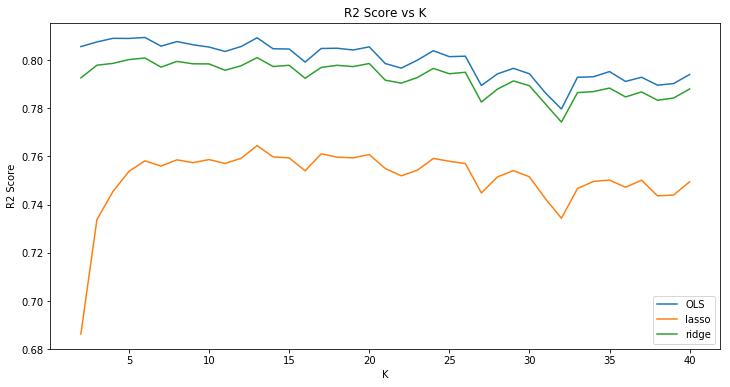

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(k_vals, avg_mse, label="OLS")
ax.plot(k_vals, lasso_avg_mse, label="lasso")
ax.plot(k_vals, ridge_avg_mse, label="ridge")
ax.set_xlabel("K")
ax.set_ylabel("Cross Validation Error")
ax.set_title("Cross Validation Error vs K")
ax.legend(loc="upper-left")
plt.show()
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = plt.subplot(111)
ax.plot(k_vals, avg_r2_score, label="OLS")
ax.plot(k_vals, lasso_avg_r2_score, label="lasso")
ax.plot(k_vals, ridge_avg_r2_score, label="ridge")
ax.set_xlabel("K")
ax.set_ylabel("R2 Score")
ax.set_title("R2 Score vs K")
ax.legend(loc="upper-left")
plt.show()

### Observations:
1. From the above graphs, it can be seen that the cross validation error initially decreases(R2 score increases), but then after a certain point starts to increase. This happens because as K increase, the no.of samples in each bucket decrease, as a result the model tends to train over almost entire dataset, hence overfitting.
2. The model performance from best to worst is OLS > Ridge(L2) > Lasso(L1). This indicates the weights obtained in OLS are important for the model prediction.

## LOOCV

Leave-one-out cross validation is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set.

In [34]:
errors = []
r2_scores = []
cv = KFold(n_splits=len(X), random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    lr = MyLinearRegressor(MSE, 0.01, 1000, 1e-15,"lasso")
    lr.fit(X_train, y_train)
    errors.append(lr.calcError(X_test, y_test))
    r2_scores.append(metrics.r2_score(y_test, lr.predict(X_test)))

In [35]:
print("LOOCV Error: {0}".format(np.mean(errors)))

LOOCV Error: 0.0018933423379008441


### Observations:
1. The Leave-one-out cross validation error is 0.002017